# Neural Net from Scratch
## Set up
---

In [1]:
import warnings

import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss as skl_log_loss
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_curve,
    precision_recall_curve
)

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
SEED = 17
RNG = np.random.default_rng(seed=SEED)

## Data Wrangling
---
This notebook builds on the [example](https://github.com/thomasnield/oreilly_essential_math_for_data_science_book/tree/main/chapter_7) presented by Thomas Nield in chapter 7 of "Essential Math for Data Science".


In [3]:
peek = pd.read_csv("https://tinyurl.com/y2qmhfsr")
peek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   RED                     1345 non-null   int64
 1   GREEN                   1345 non-null   int64
 2   BLUE                    1345 non-null   int64
 3   LIGHT_OR_DARK_FONT_IND  1345 non-null   int64
dtypes: int64(4)
memory usage: 42.2 KB


The target variable "LIGHT_OR_DARK_FONT_IND" indicates whether a dark font color would work better for a background color specified with RGB columns. Dark font would obviously be more appropriate for brighter background.

In [4]:
X = peek.iloc[:, :3].astype(float).values.copy()
X /= 255
y = peek.iloc[:, -1].values.copy()
pd.Series(y).value_counts()

1    833
0    512
Name: count, dtype: int64

In [5]:
sns.color_palette(X[y == 1][:10, :])

[(0.0, 0.6980392156862745, 0.9333333333333333),
 (0.0, 0.7490196078431373, 1.0),
 (0.0, 0.7725490196078432, 0.803921568627451),
 (0.0, 0.7803921568627451, 0.5490196078431373),
 (0.0, 0.788235294117647, 0.3411764705882353),
 (0.0, 0.803921568627451, 0.4),
 (0.0, 0.803921568627451, 0.803921568627451),
 (0.0, 0.807843137254902, 0.8196078431372549),
 (0.0, 0.8980392156862745, 0.9333333333333333),
 (0.0, 0.9333333333333333, 0.0)]

In [6]:
sns.color_palette(X[y == 0][:10, :])

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 0.5019607843137255),
 (0.0, 0.0, 0.5450980392156862),
 (0.0, 0.0, 0.803921568627451),
 (0.0, 0.0, 0.9333333333333333),
 (0.0, 0.0, 1.0),
 (0.0, 0.39215686274509803, 0.0),
 (0.0, 0.40784313725490196, 0.5450980392156862),
 (0.0, 0.5019607843137255, 0.0),
 (0.0, 0.5019607843137255, 0.5019607843137255)]

In [7]:
# splitting into train, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=SEED
)

## Building a Neural Net
---
### Forward Pass, Loss Function, Initial Evaluation

In [8]:
def relu(input):
    return np.where(input > 0, input, 0)

def logit(input):
    return 1 / (1 + np.exp(-input))

In [9]:
def forward_prop(w0, b0, w1, b1, input):
    """
    Perform forward propagation.

    Arguments
    ---------
    W0 : (4×3) array, first‐layer weights
    b0 : (4×1) array, first‐layer biases
    W1 : (1×4) array, second‐layer weights
    b1 : (1×1) array, second‐layer bias
    X  : (m×3) array, inputs (m data entries, 3 features)
    
    Returns
    -------
    Z0, A0, Z1, Z1
    """
    # transposing `input` so that each column corresponds to
    # a data entry [i.e., turning it into a column vector]
    Z0 = w0 @ input.T + b0  # shape (4, m) - 4 rows in W0 == 4 neurons
    A0 = relu(Z0)           # shape (4, m) - activated layer 0
    Z1 = w1 @ A0 + b1       # shape (1, m)
    A1 = logit(Z1)          # shape (1, m) - activated layer 1
    return Z0, A0, Z1, A1

In [10]:
def log_loss(y:np.array, y_pred:np.array):
    assert y.shape == y_pred.shape  # ensuring same input size
    return - (
        y * np.log(y_pred) + (1-y) * np.log(1 - y_pred)
    ).mean()

With `forward_prop` and `log_loss` defined, lets initialize weights and biases and see how they perform on the training set.

In [11]:
W0 = RNG.random((4, 3))
B0 = RNG.random((4, 1))

W1 = RNG.random((1, 4))
B1 = RNG.random((1, 1))

# copying to avoid aliasing after W0, B0, W1, B1 are changed
wb_init = (W0.copy(), B0.copy(), W1.copy(), B1.copy())

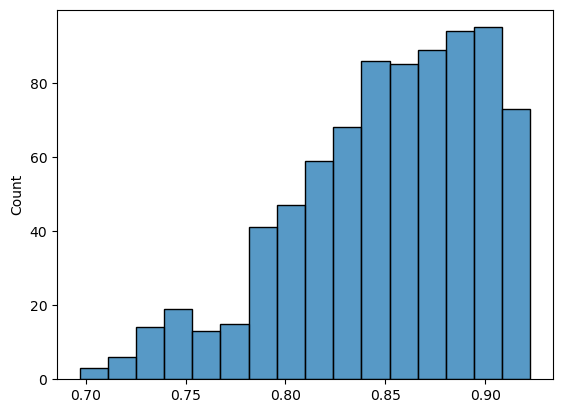

In [12]:
y_pred = forward_prop(*wb_init, X_train)[-1]
_ = sns.histplot(y_pred.ravel())

In [13]:
# accuracy
((y_pred > .5 ) == y_train).sum() / len(y_train)

0.6257744733581165

In [14]:
# benchmark accuracy
(np.ones_like(y_train) == y_train).sum() / len(y_train)

0.6257744733581165

Since all predictions (probability scores) are greater than 0.6, setting positive-class threshold to 0.5 will perform just as good as calling all training instances positive! Let's see what is the loss is for an non-optimized model.

In [15]:
log_loss(y_train, y_pred.ravel())

0.7055795316578918

Confirming with `sklearn` definition of `log_loss`:

In [16]:
skl_log_loss(y_train, y_pred.ravel())

0.7055795316578918

Let's try optimized weighs and biases from the future.

In [17]:
wb_opt = (
    np.array(
        [
            [0.69181953, 1.96397014, 0.43400268],
            [0.01619616, 0.06291352, 0.71122911],
            [0.73276473, 0.77443983, 0.27667829],
            [1.44418548, 2.96609378, 0.8093253 ]
        ]
    ),
    np.array(
        [
            [-1.02572671],
            [ 1.0940876 ],
            [-0.02472493],
            [-1.81335949]
        ]
    ),
    np.array([[ 2.11971482, -0.95797323,  0.36700971,  3.66055397]]),
    np.array([[-2.78400734]])
)

In [18]:
y_pred = forward_prop(*wb_opt, X_train)[-1]
((y_pred > .5 ) == y_train).sum() / len(y_train)

0.9876084262701363

In [19]:
log_loss(y_train, y_pred.ravel())

0.10036177295258704

### Deriving Backprop Components with `sympy`
To implement back-propagation, we need to find partial derivatives of weighs and biases relative to the loss function. To begin, let's define a few `sympy` objects (they are all suffixed with "_").

In [20]:
W0_, W1_, B0_, B1_, A0_, A1_, Z0_, Z1_, X_, Y_ = sp.symbols('W0 W1 B0 B1 A0 A1 Z0 Z1 X Y')

In [21]:
def relu_(x):
    return sp.Max(x, 0)  # notice `sp`

def logit_(x):
    return 1 / (1 + sp.exp(-x))

def forward_prop_(W0, B0, W1, B1, input):
    Z0 = W0 * input.transpose() + B0
    A0 = relu_(Z0)
    Z1 = W1 * A0 + B1
    return logit_(Z1)

def log_loss_(y, y_pred):
    # skipping averaging
    return - (y * sp.log(y_pred) + (1 - y) * sp.log(1 - y_pred))

Forward pass and log loss can be expressed with the following equations:

In [22]:
fp_ = forward_prop_(W0_, B0_, W1_, B1_, X_)
fp_

1/(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1)

In [23]:
log_loss_(Y_, fp_)

-Y*log(1/(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1)) - (1 - Y)*log(1 - 1/(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1))

So the derivative for for `W1` will be...

In [24]:
sp.diff(log_loss_(Y_, fp_), W1_)

-Y*exp(-B1 - W1*Max(0, B0 + W0*transpose(X)))*Max(0, B0 + W0*transpose(X))/(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1) + (1 - Y)*exp(-B1 - W1*Max(0, B0 + W0*transpose(X)))*Max(0, B0 + W0*transpose(X))/((1 - 1/(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1))*(exp(-B1 - W1*Max(0, B0 + W0*transpose(X))) + 1)**2)

... which is not exactly helpful. Instead, let's exploit chain rule to methodically work through the sequence of derivatives starting from $\frac{dC}{dA1}$ (cost function relative to the final activated layer, `A1`).

In [25]:
# Calculate derivative of cost function with respect to A1
C = log_loss_(Y_, A1_)
dC_dA1 = sp.diff(C, A1_)
print("dC_dA1 = ", dC_dA1)

dC_dA1 =  (1 - Y)/(1 - A1) - Y/A1


In [26]:
# Calculate derivative of A1 with respect to Z1
dA1_dZ1 = sp.diff(logit_(Z1_), Z1_)
print("dA1_dZ1 = ", dA1_dZ1)

dA1_dZ1 =  exp(-Z1)/(1 + exp(-Z1))**2


In [27]:
# Calculate derivative of Z1 with respect to A0
dZ1_dA0 = sp.diff(A0_ * W1_ + B1_, A0_)
print("dZ1_dA0 = ", dZ1_dA0) # W1

dZ1_dA0 =  W1


In [28]:
# Calculate derivative of Z1 with respect to W1
dZ1_dW1 = sp.diff(A0_ * W1_ + B1_, W1_)
print("dZ1_dW1 = ", dZ1_dW1) # A1

dZ1_dW1 =  A0


In [29]:
# Calculate derivative of Z1 with respect to B1
dZ1_dB1 = sp.diff(A0_ * W1_ + B1_, B1_)
print("dZ1_dB1 = ", dZ1_dB1) # 1

dZ1_dB1 =  1


In [30]:
# Calculate derivative of A0 with respect to Z0
d_relu_ = lambda x: x > 0 # Slope is 1 if positive, 0 if negative
dA0_dZ0 = d_relu_(Z0_)
print("dA0_dZ0 = ", dA0_dZ0) # Z0 > 0

dA0_dZ0 =  Z0 > 0


In [31]:
# Calculate derivative of Z0 with respect to W0
dZ0_dW0 = sp.diff(X_ * W0_ + B0_, W0_)
print("dZ0_dW0 = ", dZ0_dW0) # X

dZ0_dW0 =  X


In [32]:
# Calculate derivative of Z0 with respect to B0
dZ0_dB0 = sp.diff(X_ * W0_ + B0_, B0_)
print("dZ0_dB0 = ", dZ0_dB0) # 1

dZ0_dB0 =  1


### Defining Backprop
Let's convert the derivatives to numpy expressions.

In [33]:
Z0, A0, Z1, A1 = forward_prop(*wb_init, X_train)
dC_dA1 =  (1 - y_train) / (1 - A1) - y_train / A1
dA1_dZ1 = np.exp(-Z1)/(1 + np.exp(-Z1))**2
dZ1_dA0 = W1
dZ1_dW1 = A0
dZ1_dB1 = 1
dA0_dZ0 = Z0 > 0
dZ0_dW0 = X.T
dZ0_dB0 = 1

Derivatives of interest are:<br><br>
$\frac{dC}{dW1} = \frac{dC}{dA1}\frac{dA1}{dZ1}\frac{dZ1}{dW1}$ <br><br>
$\frac{dC}{dB1} = \frac{dC}{dA1}\frac{dA1}{dZ1}\frac{dZ1}{dB1}$ <br><br>
$\frac{dC}{dW0} = \frac{dC}{dA1}\frac{dA1}{dZ1}\frac{dZ1}{dA0}\frac{dA0}{dZ0}\frac{dZ0}{dW0}$ <br><br>
$\frac{dC}{dB0} = \frac{dC}{dA1}\frac{dA1}{dZ1}\frac{dZ1}{dA0}\frac{dA0}{dZ0}\frac{dZ0}{dB0}$ <br><br>

It turns out that the most "clumsy" derivative, $\frac{dC}{dZ1}$:

In [34]:
dC_dZ1 = dC_dA1 * dA1_dZ1

...is equivalent to the difference between `A1` and `Y`.

In [35]:
np.isclose(
    dC_dZ1,
    A1 - y_train.reshape(1, -1)
).all()

True

With that we are ready to proceed to `gradient_update` that completes backprop and returns updated weights.

In [36]:
def gradient_update(
    w0, b0, w1, b1, X, y, lr,
    batch_size=None
):
    """
    Perform one gradient descent step.

    Arguments
    ---------
    w0 : (4×3) array, first‐layer weights
    b0 : (4×1) array, first‐layer biases
    w1 : (1×4) array, second‐layer weights
    b1 : (1×1) array, second‐layer bias
    X  : (m×3) array, inputs (m examples)
    y  : (m,)  array, binary labels {0,1}
    lr :       float, learning rate
    batch_size :      Optional[int], number of data entries for update

    Returns
    -------
    Updated w0, b0, w1, b1
    """
    if batch_size:
        assert batch_size < X.shape[0]
        idx = RNG.choice(range(X.shape[0]), batch_size)
        X = X[idx].copy()
        y = y[idx].copy()
    
    m = X.shape[0]

    # —— Forward propagation —— 
    Z0, A0, Z1, A1 = forward_prop(w0, b0, w1, b1, X)

    # —— Backward propagation —— 
    # dC/dZ1 for cross‐entropy+sigmoid simplifies to (A1 – y)
    dZ1 = A1 - y.reshape(1, m)       # shape (1, m)

    # gradients for layer 1→2
    dW1 = (dZ1 @ A0.T) / m           # shape (1, 4)
    dB1 = np.mean(dZ1, axis=1, keepdims=True)  # shape (1, 1)

    # backprop into hidden units
    dA0 = W1.T @ dZ1                 # shape (4, m)
    dZ0 = dA0 * (Z0 > 0)             # shape (4, m), ReLU’ = 1_{Z0>0}

    # gradients for layer 0→1
    dW0 = (dZ0 @ X) / m              # shape (4, 3)
    dB0 = np.mean(dZ0, axis=1, keepdims=True)  # shape (4, 1)

    # —— Parameter update —— 
    w0 -= lr * dW0
    b0 -= lr * dB0
    w1 -= lr * dW1
    b1 -= lr * dB1

    return w0, b0, w1, b1

Let's see if it works!

In [37]:
gradient_update(
            W0, B0, W1, B1, X_train, y_train, 0.2,
            batch_size=1
        )

(array([[ 0.75265601,  0.13845087,  0.50338056],
        [ 0.26885435,  0.19076094,  0.32745604],
        [ 0.42703657,  0.61106823,  0.73572238],
        [-0.01387255,  0.24693416,  0.58699161]]),
 array([[-0.01528343],
        [ 0.89145055],
        [ 0.83113763],
        [ 0.00553214]]),
 array([[ 0.35550342,  0.32983183, -0.30281582,  0.10222566]]),
 array([[-0.00955035]]))

In [38]:
wb_init

(array([[0.84507479, 0.16097309, 0.55774455],
        [0.36807994, 0.21494196, 0.38582404],
        [0.4281645 , 0.61134311, 0.73638587],
        [0.01528966, 0.25404091, 0.60414585]]),
 array([[0.08373669],
        [0.99776368],
        [0.83234612],
        [0.03677736]]),
 array([[0.56753981, 0.60934014, 0.00692658, 0.17908387]]),
 array([[0.16492221]]))

Comparing the `gradient_update` output with the initialized weights and biases, something has clearly happened.
Let's see if it is any good for model training.

## Model Training
---

In [39]:
def train_baby_train(
    weights_and_biases, n_epochs=2_000, lr=0.2, batch_size=None
):
    """
    Update weights for `n_epochs` steps.

    Arguments
    ---------
    weights_and_biases : (4,) array-like
    n_epochs:    int,          number of
    lr :         float,        learning rate
    batch_size : Optional[int], number of data entries for update 

    Returns
    -------
    Updated (w0, b0, w1, b1), training log
    """
    w0 = weights_and_biases[0].copy()
    b0 = weights_and_biases[1].copy()
    w1 = weights_and_biases[2].copy()
    b1 = weights_and_biases[3].copy()

    train_loss_log, val_loss_log = [], []

    for epoch in range(n_epochs):
        w0, b0, w1, b1 = gradient_update(
            w0, b0, w1, b1, X_train, y_train, lr,
            batch_size=batch_size
        )
    
        *_, A1_train = forward_prop(w0, b0, w1, b1, X_train)
        *_, A1_val = forward_prop(w0, b0, w1, b1, X_val)
    
        train_loss = log_loss(y_train, A1_train.ravel())
        val_loss = log_loss(y_val, A1_val.ravel())
        
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}, Train Loss = {train_loss:.4f} Eval Loss = {val_loss:.4f}")

    log = pd.DataFrame(
        np.array([train_loss_log, val_loss_log]).T,
        index=pd.Index(range(n_epochs), name="epoch"),
        columns=pd.Index(["train_loss", "val_loss"], name="entropy_loss")
    )
    return (w0, b0, w1, b1), log

Epoch    0, Train Loss = 0.6597 Eval Loss = 0.6810
Epoch  100, Train Loss = 0.4241 Eval Loss = 0.4505
Epoch  200, Train Loss = 0.2984 Eval Loss = 0.3323
Epoch  300, Train Loss = 0.2277 Eval Loss = 0.2627
Epoch  400, Train Loss = 0.1862 Eval Loss = 0.2195
Epoch  500, Train Loss = 0.1601 Eval Loss = 0.1911
Epoch  600, Train Loss = 0.1425 Eval Loss = 0.1713
Epoch  700, Train Loss = 0.1299 Eval Loss = 0.1569
Epoch  800, Train Loss = 0.1205 Eval Loss = 0.1460
Epoch  900, Train Loss = 0.1132 Eval Loss = 0.1373
Epoch 1000, Train Loss = 0.1072 Eval Loss = 0.1303
Epoch 1100, Train Loss = 0.1023 Eval Loss = 0.1245
Epoch 1200, Train Loss = 0.0981 Eval Loss = 0.1195
Epoch 1300, Train Loss = 0.0945 Eval Loss = 0.1152
Epoch 1400, Train Loss = 0.0913 Eval Loss = 0.1113
Epoch 1500, Train Loss = 0.0885 Eval Loss = 0.1079
Epoch 1600, Train Loss = 0.0860 Eval Loss = 0.1049
Epoch 1700, Train Loss = 0.0837 Eval Loss = 0.1021
Epoch 1800, Train Loss = 0.0817 Eval Loss = 0.0995
Epoch 1900, Train Loss = 0.0798

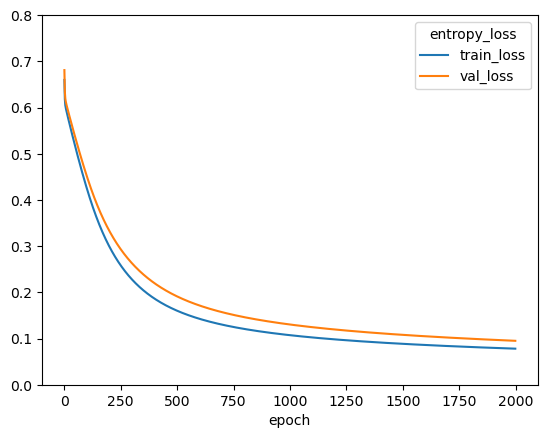

In [40]:
%%time
# batch gradient descent (using all training data for update)
wb_opt_bgd, log_bgd = train_baby_train(wb_init)
log_bgd.plot(ylim=(0, 0.8));

Epoch    0, Train Loss = 0.6712 Eval Loss = 0.6935
Epoch  100, Train Loss = 0.4266 Eval Loss = 0.4526
Epoch  200, Train Loss = 0.2997 Eval Loss = 0.3332
Epoch  300, Train Loss = 0.2288 Eval Loss = 0.2632
Epoch  400, Train Loss = 0.1859 Eval Loss = 0.2183
Epoch  500, Train Loss = 0.1601 Eval Loss = 0.1906
Epoch  600, Train Loss = 0.1429 Eval Loss = 0.1720
Epoch  700, Train Loss = 0.1318 Eval Loss = 0.1582
Epoch  800, Train Loss = 0.1220 Eval Loss = 0.1467
Epoch  900, Train Loss = 0.1135 Eval Loss = 0.1371
Epoch 1000, Train Loss = 0.1075 Eval Loss = 0.1297
Epoch 1100, Train Loss = 0.1030 Eval Loss = 0.1245
Epoch 1200, Train Loss = 0.0990 Eval Loss = 0.1226
Epoch 1300, Train Loss = 0.0948 Eval Loss = 0.1153
Epoch 1400, Train Loss = 0.0916 Eval Loss = 0.1131
Epoch 1500, Train Loss = 0.0887 Eval Loss = 0.1072
Epoch 1600, Train Loss = 0.0863 Eval Loss = 0.1062
Epoch 1700, Train Loss = 0.0839 Eval Loss = 0.1030
Epoch 1800, Train Loss = 0.0817 Eval Loss = 0.0990
Epoch 1900, Train Loss = 0.0837

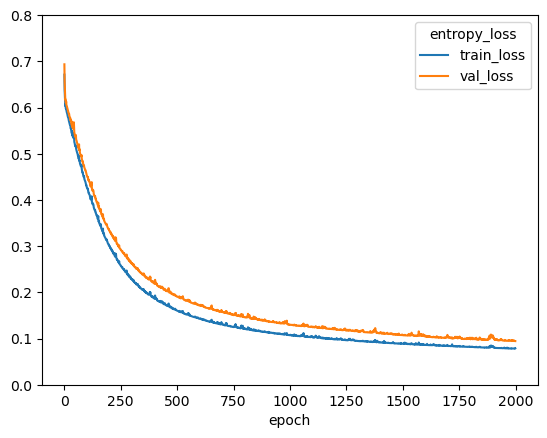

In [41]:
%%time
# mini-batch gradient descent (using a sample of 32 training entries for every updated)
wb_opt_mbgd, log_mbgd = train_baby_train(wb_init, batch_size=32)
log_mbgd.plot(ylim=(0, 0.8));

Epoch    0, Train Loss = 0.6347 Eval Loss = 0.6407
Epoch  100, Train Loss = 0.5186 Eval Loss = 0.5541
Epoch  200, Train Loss = 0.2929 Eval Loss = 0.3286
Epoch  300, Train Loss = 0.2910 Eval Loss = 0.3314
Epoch  400, Train Loss = 0.2940 Eval Loss = 0.3409
Epoch  500, Train Loss = 0.1577 Eval Loss = 0.1929
Epoch  600, Train Loss = 0.2330 Eval Loss = 0.2879
Epoch  700, Train Loss = 0.1614 Eval Loss = 0.2051
Epoch  800, Train Loss = 0.1349 Eval Loss = 0.1717
Epoch  900, Train Loss = 0.1458 Eval Loss = 0.1694
Epoch 1000, Train Loss = 0.1287 Eval Loss = 0.1679
Epoch 1100, Train Loss = 0.1081 Eval Loss = 0.1318
Epoch 1200, Train Loss = 0.1196 Eval Loss = 0.1555
Epoch 1300, Train Loss = 0.1202 Eval Loss = 0.1403
Epoch 1400, Train Loss = 0.0877 Eval Loss = 0.1124
Epoch 1500, Train Loss = 0.0889 Eval Loss = 0.1150
Epoch 1600, Train Loss = 0.0925 Eval Loss = 0.1219
Epoch 1700, Train Loss = 0.0940 Eval Loss = 0.1046
Epoch 1800, Train Loss = 0.0946 Eval Loss = 0.1222
Epoch 1900, Train Loss = 0.0773

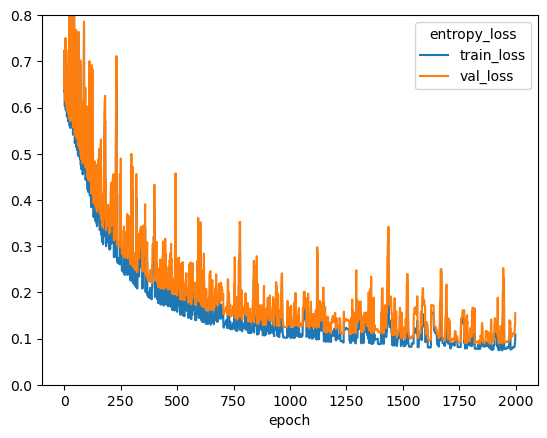

In [42]:
%%time
# stochastic gradient descent (using a sample of 32 training entries for every updated)
wb_opt_sgd, log_sgd = train_baby_train(wb_init, batch_size=1)
log_sgd.plot(ylim=(0, 0.8));

Interestingly, batch gradient is the fastest, possibly due to the clumsy `if` condition for drawing a subset from the data if `batch_size` is not `None`. Stochastic gradient descent is marginally faster than mini-batches of size 32.

We can now proceed to evaluation on the test set.

## Model Evaluation
---
The comprehensive function below will be handy for this section.

In [43]:
def plot_classification_performance(
    y_true,
    y_prob,
    pos_label=1,
    threshold=0.5,
    figsize=(10, 4),
    n_thresholds=10
):
    """
    Plot confusion matrix, ROC, and precision-recall curves with threshold annotations.

    Args
    ----
        y_true (array-like): True labels.
        y_prob (array-like): Predicted probabilities.
        pos_label (int/str): Positive class.
        threshold (float): Cutoff for predictions.
        figsize (tuple): Figure size.
        n_thresholds (int): Number of threshold markers.

    Returns
    -------
        matplotlib.figure.Figure
    """
    y_score = np.array(y_prob)
    if y_score.ndim == 2:
        y_score = y_score[:, 1]
    elif y_score.ndim != 1:
        raise ValueError("y_prob must be (n,) or (n,2)")

    y_pred = (y_score >= threshold).astype(int)
    fpr, tpr, roc_thresholds = roc_curve(
        y_true, y_score, pos_label=pos_label)
    precision, recall, pr_thresholds = precision_recall_curve(
        y_true, y_score, pos_label=pos_label)

    fig, axes = plt.subplots(1, 3, figsize=figsize, tight_layout=True)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap='Blues', colorbar=False, ax=axes[0]
    )
    axes[0].set_title(f"Confusion Matrix (thr={threshold:.2f})")
    axes[0].grid(False)

    # ROC Curve
    ax = axes[1]
    RocCurveDisplay.from_predictions(
        y_true, y_score, pos_label=pos_label, ax=ax
    )
    ax.set_title("ROC Curve")
    ax.grid(True, linestyle='--', alpha=0.7)
    idxs = np.linspace(0, len(roc_thresholds) - 1, n_thresholds, dtype=int)
    # scatter with color mapping
    ax.scatter(
        fpr[idxs], tpr[idxs], s=50, c=roc_thresholds[idxs],
        cmap='Blues', edgecolor='k', zorder=2
    )
    for i in idxs:
        x, y = fpr[i], tpr[i]
        ax.annotate(
            f"{roc_thresholds[i]:.2f}", (x, y),
            textcoords="offset points", xytext=(5,-5), zorder=3
        )

    # Precision-Recall Curve
    ax = axes[2]
    PrecisionRecallDisplay.from_predictions(
        y_true, y_score, pos_label=pos_label, ax=ax
    )
    ax.set_title("Precision-Recall Curve")
    ax.grid(True, linestyle='--', alpha=0.7)
    idxs = np.linspace(0, len(pr_thresholds) - 1, n_thresholds, dtype=int)
    # scatter with color mapping
    ax.scatter(
        recall[idxs], precision[idxs], s=50, c=pr_thresholds[idxs],
        cmap='Blues', edgecolor='k', zorder=2
    )
    for j in idxs:
        x, y = recall[j], precision[j]
        ax.annotate(
            f"{pr_thresholds[j]:.2f}", (x, y),
            textcoords="offset points", xytext=(5,-5), zorder=3
        )

    return fig

This is what we started with

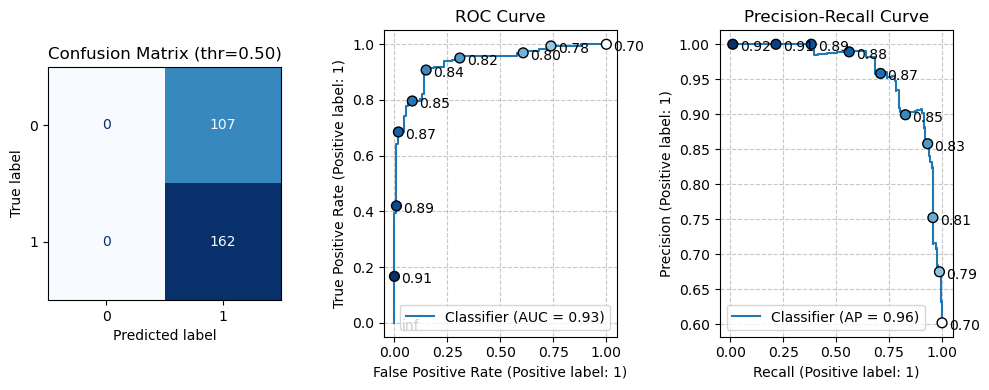

In [44]:
y_prob = forward_prop(*wb_init, X_test)[-1]
_ = plot_classification_performance(y_test, y_prob.ravel())

Not bad for randomly initiated weights! Let's see how well the weights tuned with stochastic gradient descent performed.

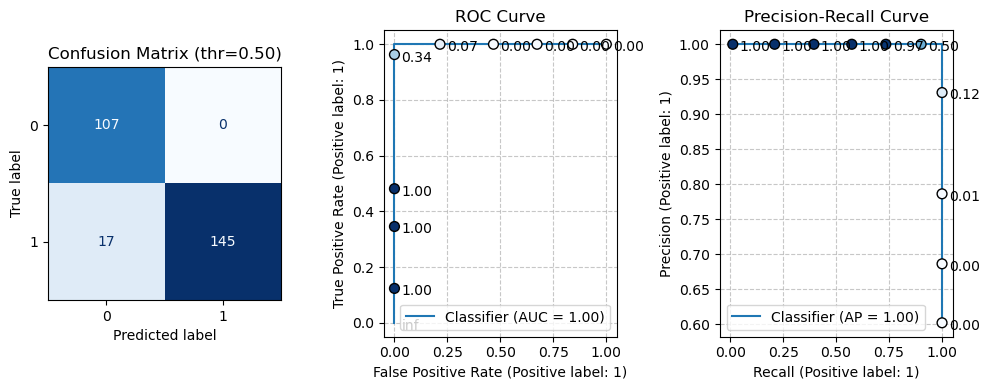

In [45]:
y_prob = forward_prop(*wb_opt_sgd, X_test)[-1]
_ = plot_classification_performance(y_test, y_prob.ravel())

After slight threshold hacking, perfect performance on the test set was achieved:

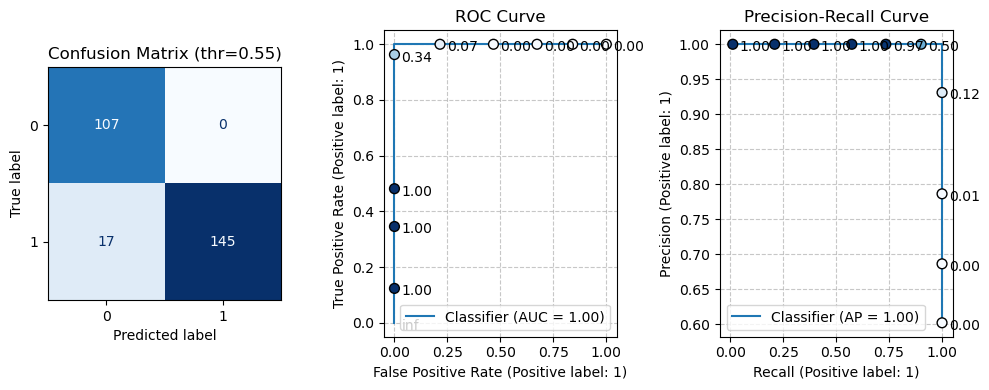

In [46]:
_ = plot_classification_performance(y_test, y_prob.ravel(), threshold=.55)

## Animation
---

## Building Custom Class
---

## Pytorch Implementation
---